# Football Manager 2024 - Player Valuation Analysis

An attempt to model player valuation based on their attributes to find undervalued attributes.

### Data Loading

In [328]:
import pandas as pd
import numpy as np
import datetime as dt


# Importing the dataset into a pandas dataframe
file = "data/Export 10K players.rtf"
df = pd.read_csv(file, delimiter="|")

### Data Pre-Processing

In [329]:
df = df.rename(columns=str.strip) #stripping column names
df.dropna(subset=["Height"], inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

# Strip spaces, and convert wage to a float
df["Wage"] = df["Wage"].str.strip()
df["Wage"] = df["Wage"].str.replace("£", "", regex=True)
df["Wage"] = df["Wage"].str.replace(",", "", regex=True)
df["Wage"] = df["Wage"].str.replace(" p/w", "", regex=True)
df["Wage"] = df["Wage"].astype(float)

# Handling the string for transfer value and creating an average float value between min and max estimate.
df[["Min Value", "Max Value"]] = df["Transfer Value"].str.split(" - ", expand=True)
df["Min Value"] = df["Min Value"].str.strip().str.replace("£", "")
df["Min Value"] = df["Min Value"].replace("Not for Sale", np.nan)
df["Max Value"] = df["Max Value"].str.strip().str.replace("£", "")

def convert_values(value):
    if pd.isna(value):
        return np.nan
    elif "M" in value:
        return float(value.replace("M", "")) * 1000000
    elif "K" in value:
        return float(value.replace("K", "")) * 1000
    else:
        return float(value)
    
df["Min Value"] = df["Min Value"].apply(convert_values)
df["Max Value"] = df["Max Value"].apply(convert_values)
df["Avg Value"] = (df["Min Value"] + df["Max Value"]) / 2

# Converting the height data into cm
df[["height_feet", "height_inch"]]= pd.DataFrame(df["Height"].str.strip().str.replace('"', "").str.split("'").to_list(), index=df.index).astype(int)
df["height_cm"] = (((df["height_feet"] * 12) + (df["height_inch"])) * 2.54).astype(float)


# Converting the contract expiry date into years remaining
start_date = dt.datetime.strptime('2023-09-01', "%Y-%m-%d")
df["Expires"] = pd.to_datetime(df["Expires"], dayfirst=True)
df["Months Remaining"] = round(((df["Expires"] - start_date).dt.days / 30.4375),0)


# Drop any rows will nulls.
df = df.dropna()


# Outputting the cleansed data to csv for checking
df.to_csv("data/output.csv")

### Exploratory Data Analysis

count    1.055400e+04
mean     5.878477e+06
std      1.523408e+07
min      2.000000e+05
25%      6.600000e+05
50%      1.325000e+06
75%      4.400000e+06
max      2.235000e+08
Name: Avg Value, dtype: float64


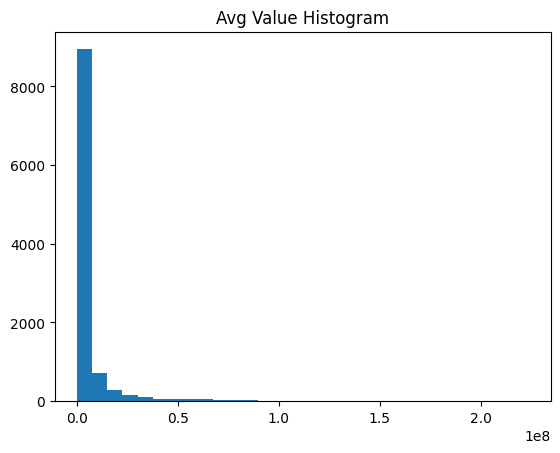

In [330]:
# Creating a histogram on the target variable.
import matplotlib.pyplot as plt

print(df["Avg Value"].describe())

plt.hist(df["Avg Value"], bins=30)
plt.title("Avg Value Histogram")
plt.show()

As you can see, the target variable is heavily right skewed. Therefore, I will apply a log transformation.

count    10554.000000
mean        14.403761
std          1.368438
min         12.206073
25%         13.399995
50%         14.096923
75%         15.297115
max         19.224922
Name: Log Avg Value, dtype: float64


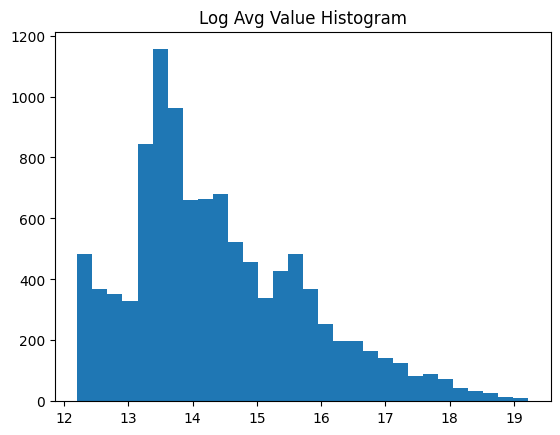

In [331]:
# Applying log transformtation on target variable
df["Log Avg Value"] = np.log(df["Avg Value"])
print(df["Log Avg Value"].describe())
plt.hist(df["Log Avg Value"], bins=30)
plt.title("Log Avg Value Histogram")
plt.show()

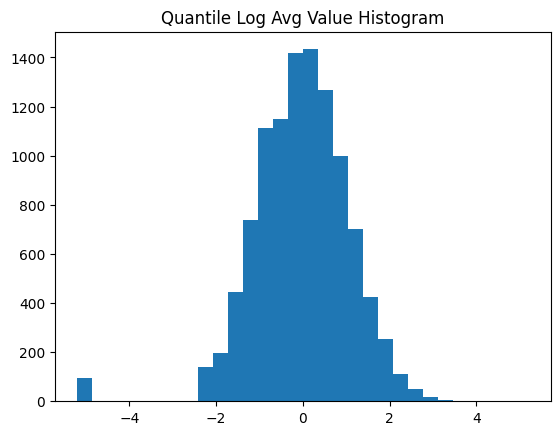

In [332]:
from sklearn.preprocessing import QuantileTransformer

# Applying a quantile transformation to ge the y variable into a more normal distribution
quantile_transformer = QuantileTransformer(output_distribution="normal", random_state=42)
df["Quantile Log Avg Value"] = quantile_transformer.fit_transform(df[["Log Avg Value"]])

plt.hist(df["Quantile Log Avg Value"], bins=30)
plt.title("Quantile Log Avg Value Histogram")
plt.show()

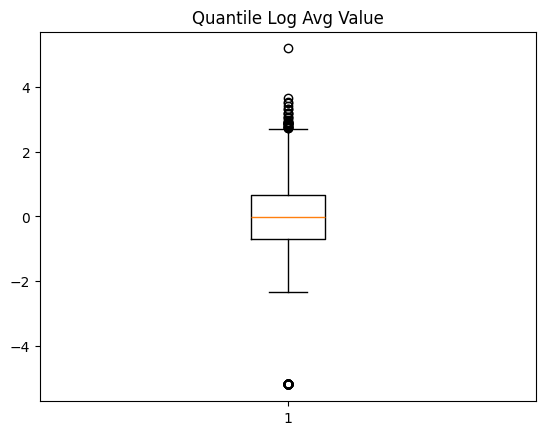

In [333]:
# Going to plot a boxplot to check for outliers after applying quantile log transformation on y.

plt.boxplot(x=df["Quantile Log Avg Value"])
plt.title("Quantile Log Avg Value")
plt.show()

There appears to be a lot of outliers. I am going to remove these.

In [334]:
# Filtering out outliers that are the interquartile range above or below the third and first quartiles.
Q1 = df["Quantile Log Avg Value"].quantile(0.25)
Q3 = df["Quantile Log Avg Value"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

df = df[(df["Quantile Log Avg Value"] >= lower_bound) & (df["Quantile Log Avg Value"] <= upper_bound)]

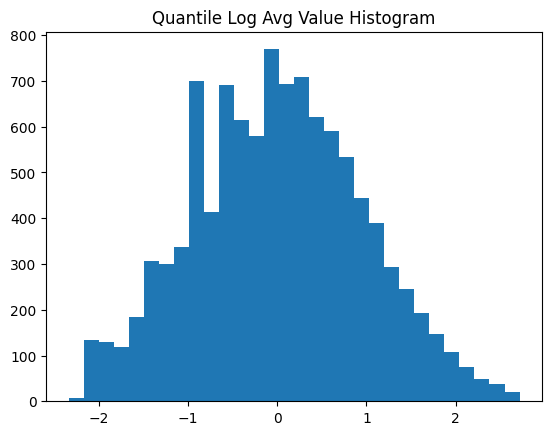

In [335]:
plt.hist(df["Quantile Log Avg Value"], bins=30)
plt.title("Quantile Log Avg Value Histogram")
plt.show()

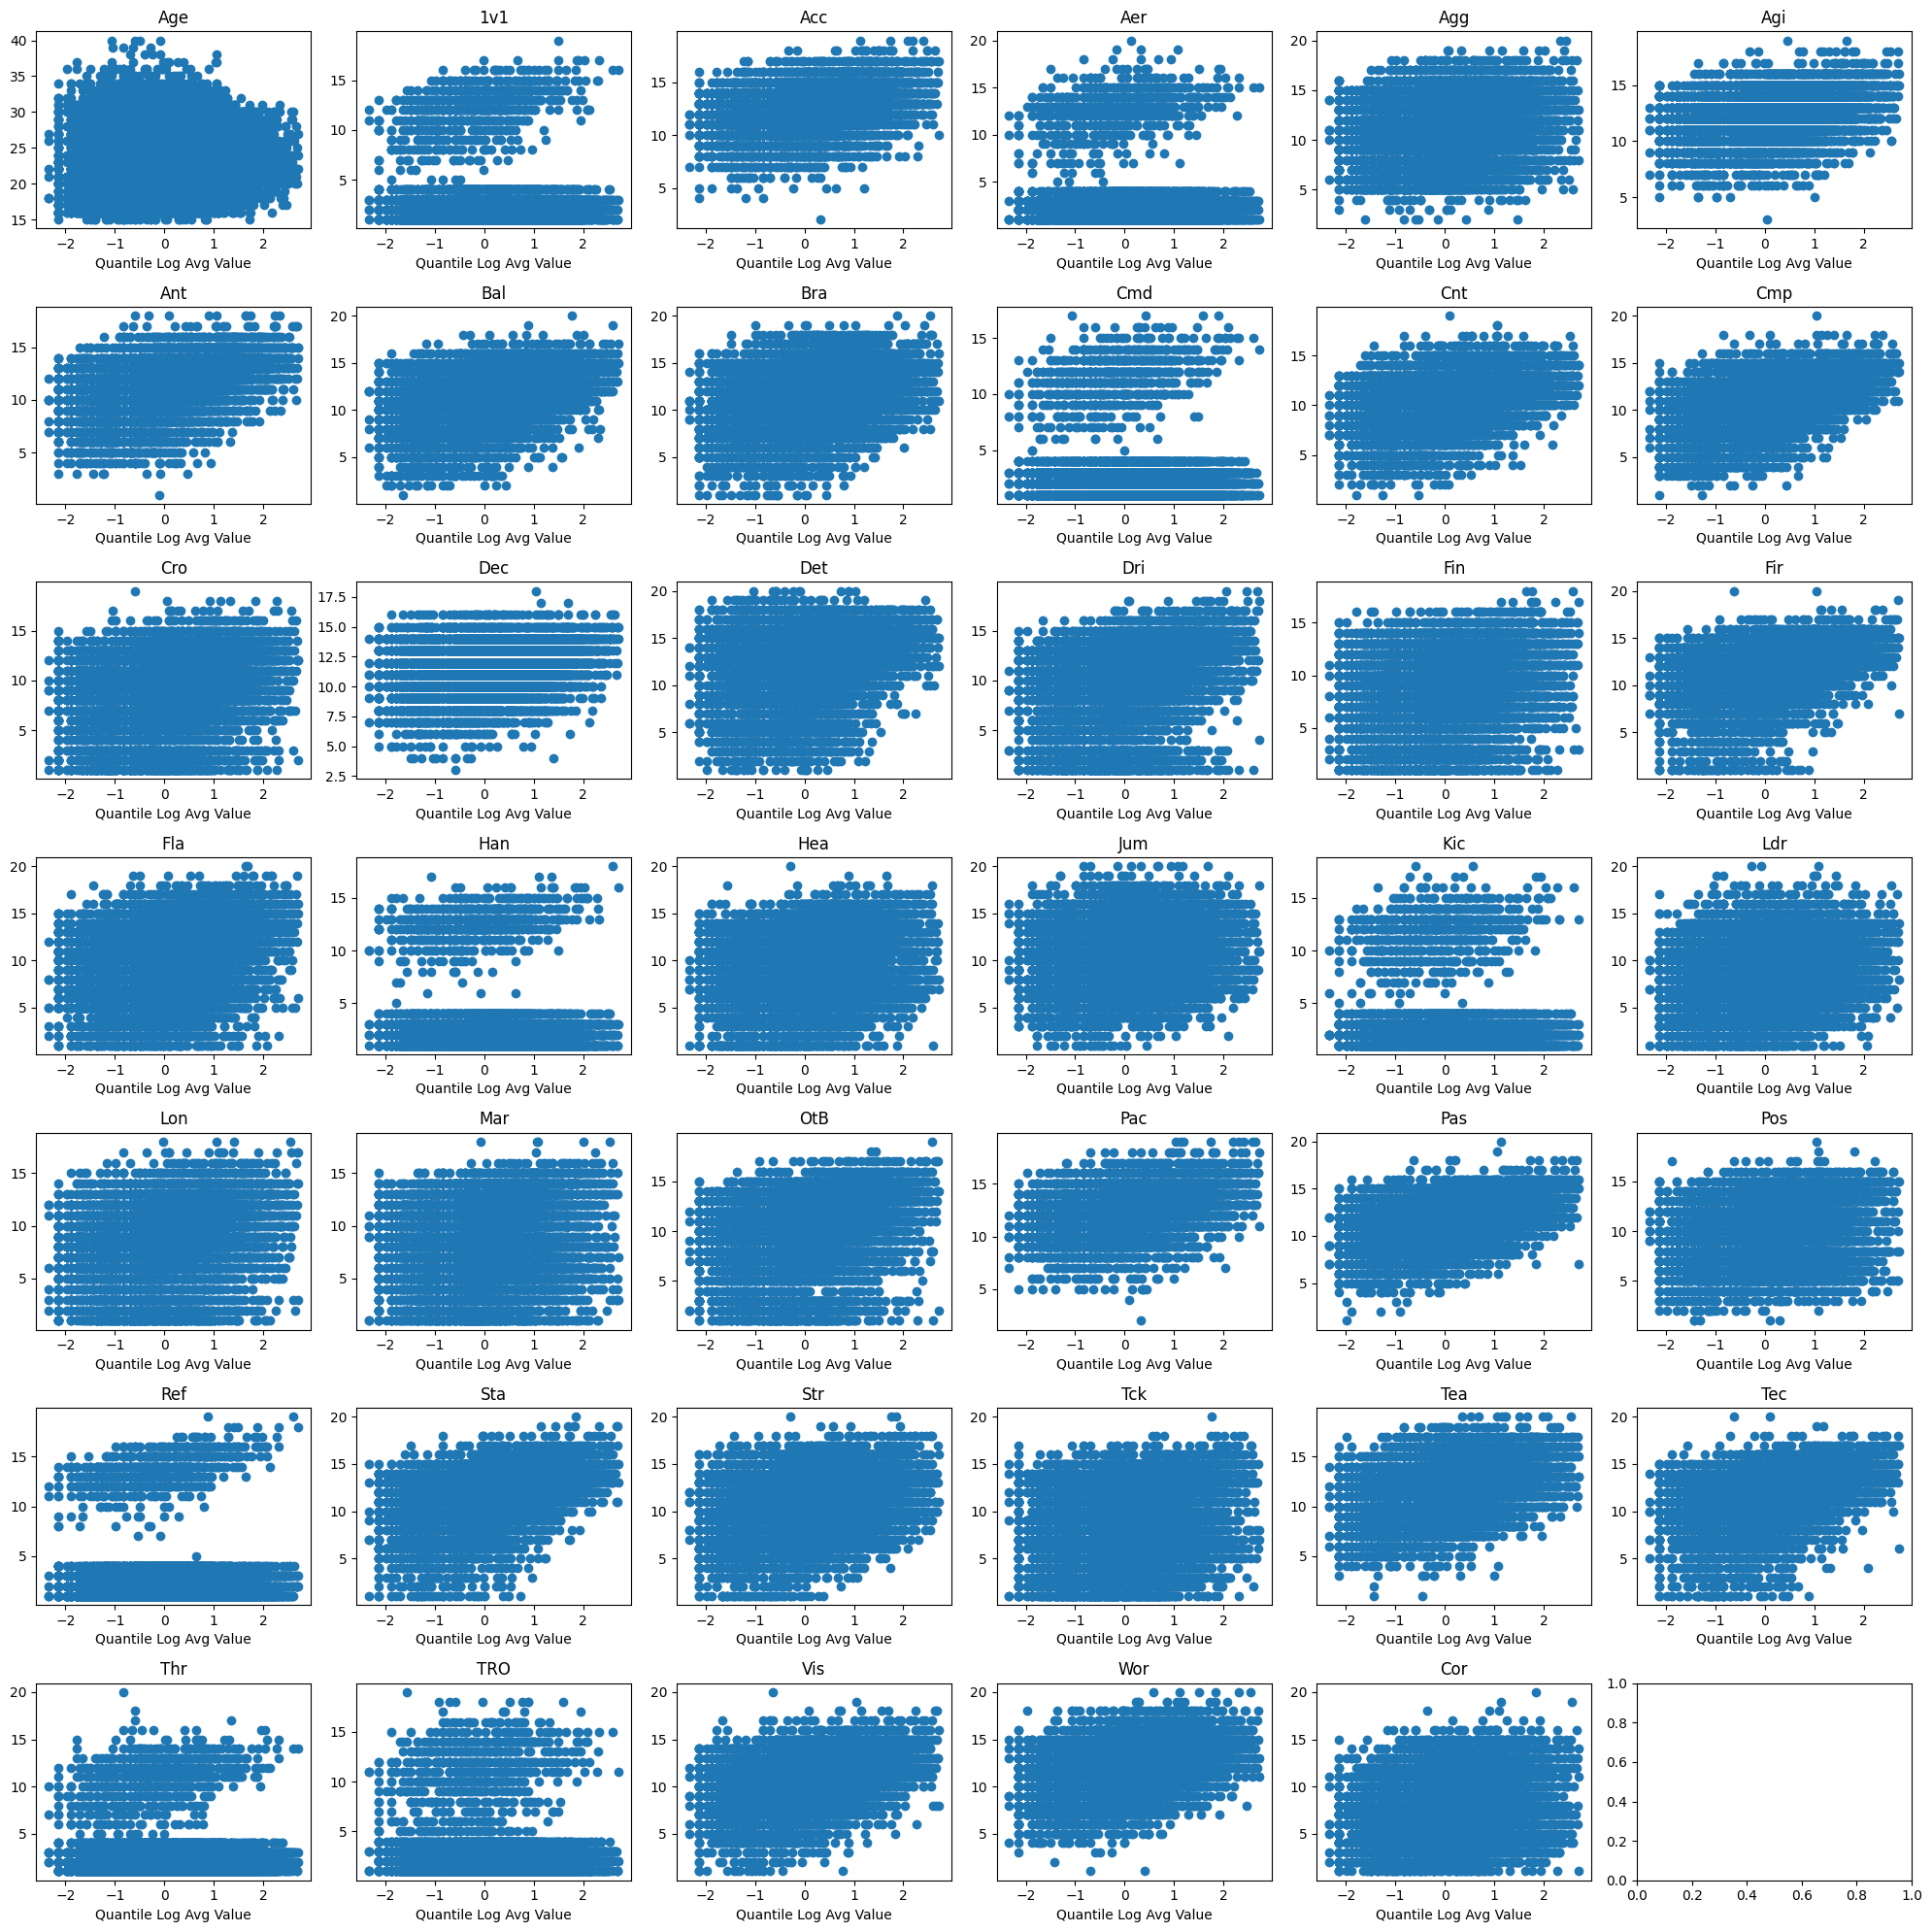

In [336]:
#Creating a grid of scatter plots, plotting the continuous features against y

n_rows, n_cols = 7, 6
columns = ["Age", "1v1", "Acc", "Aer", "Agg", "Agi", "Ant", "Bal", "Bra", "Cmd", "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla", "Han", "Hea", "Jum", "Kic", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Ref", "Sta", "Str", "Tck", "Tea", "Tec", "Thr", "TRO", "Vis",
               "Wor", "Cor"]
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))
axes = axes.flatten()
for i, col in enumerate(columns):
    axes[i].scatter(df["Quantile Log Avg Value"], df[col])
    axes[i].set_title(col)
    axes[i].set_xlabel("Quantile Log Avg Value")

plt.tight_layout()
plt.show()

As you can see from above, a clear insight to take from this is that the GK attributes are messing up everying else. The decision here should be to separate the model into a GK and an outfield model.

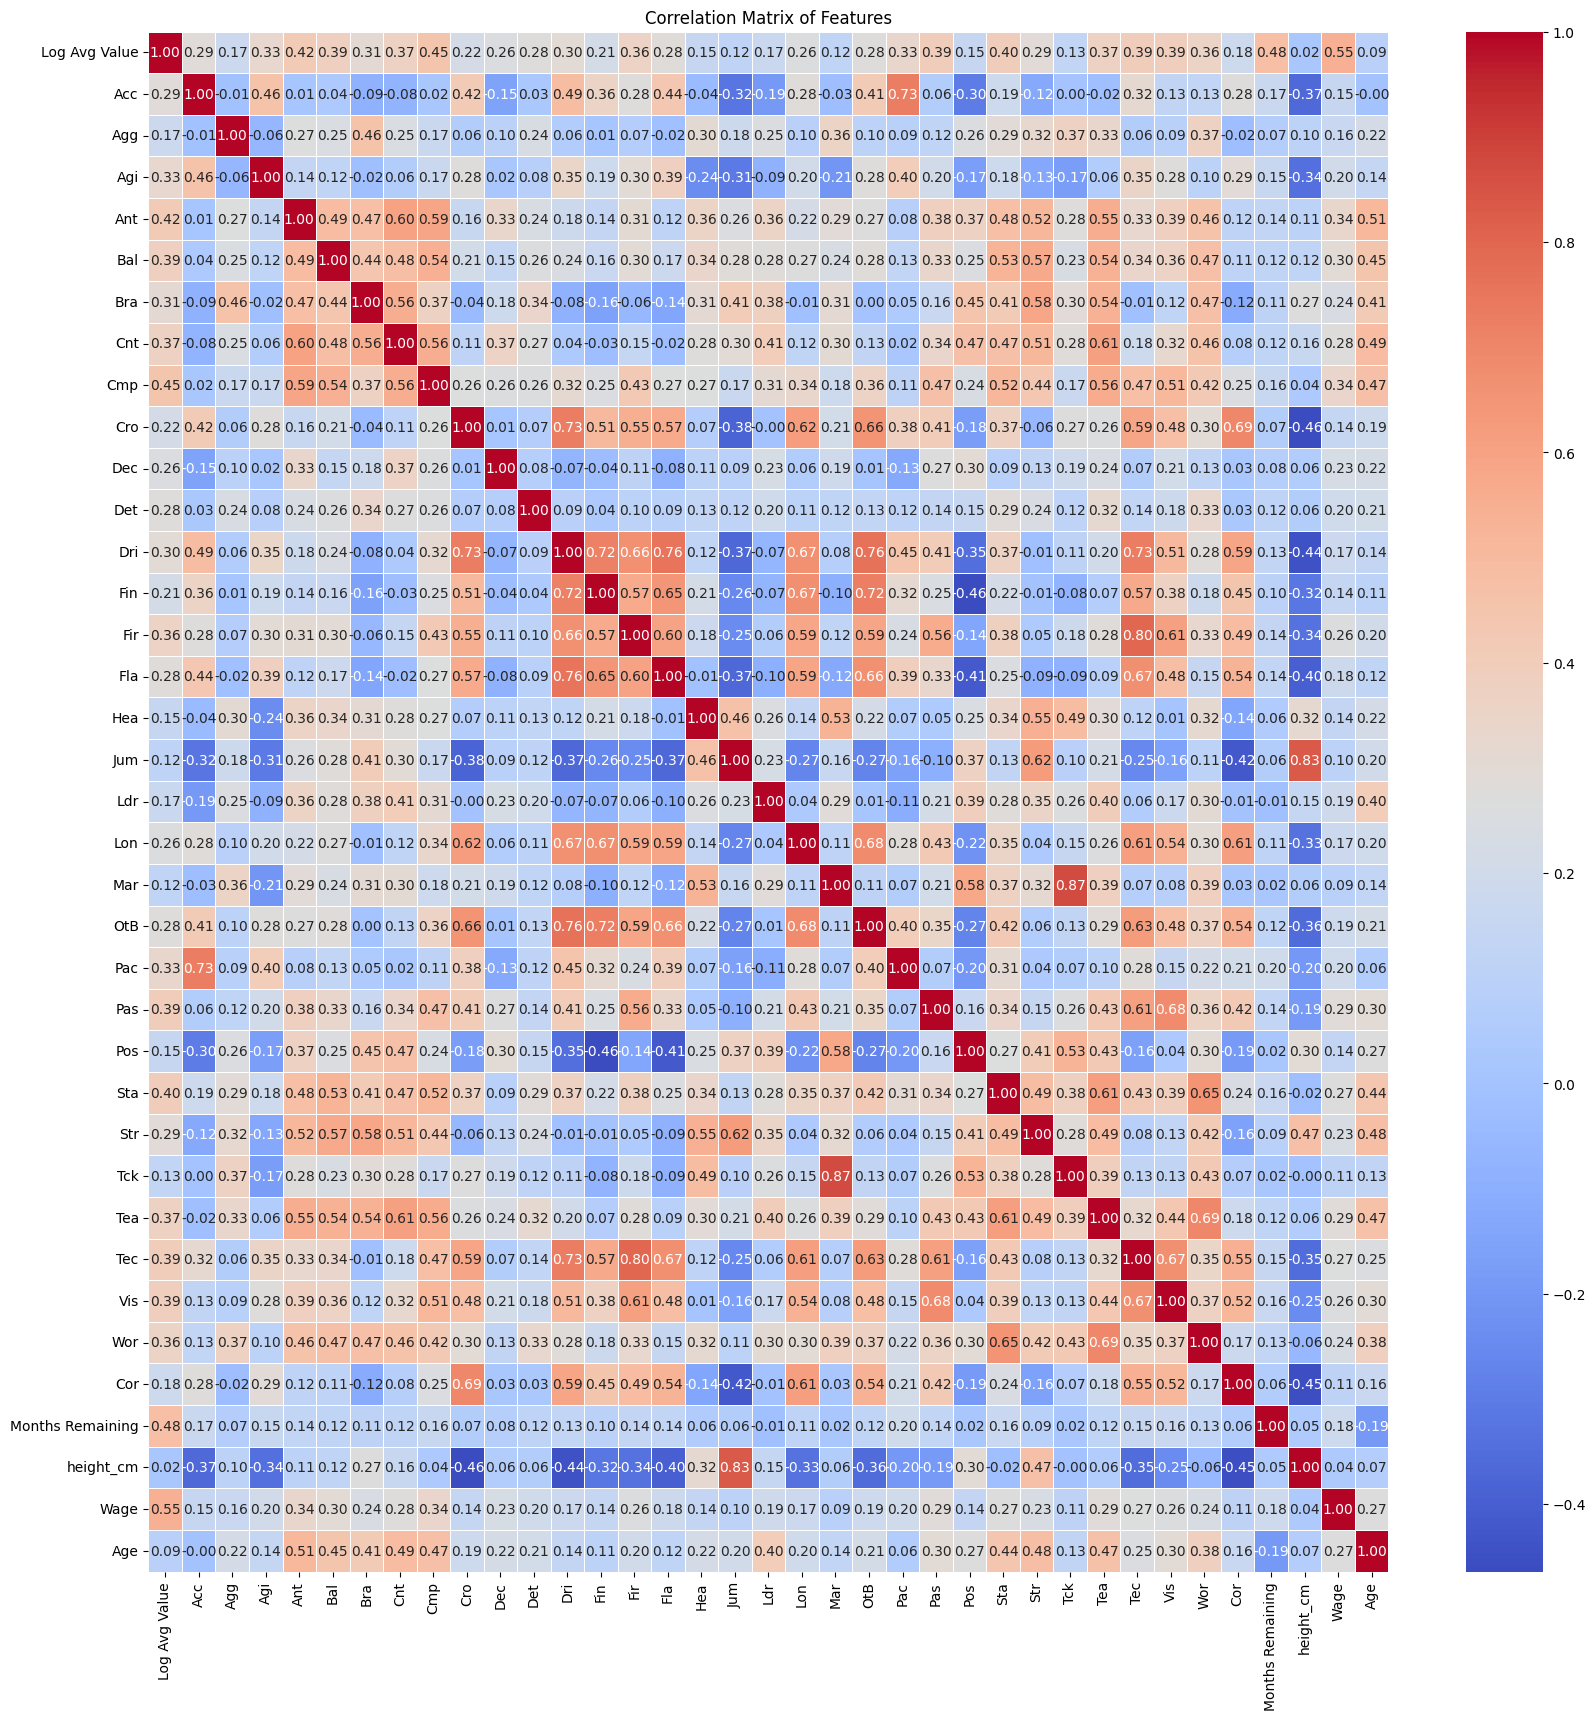

In [337]:
import seaborn as sns


# Creating a correlation matrix between all of the features
corr_matrix = df[["Log Avg Value", "Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Jum", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tck", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Months Remaining", "height_cm", "Wage", "Age"]].corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of Features")
plt.show()

I wouldn't say there are any big issues with the correlation matrix, however one insight is that some features could be merged, particularly the features that have a corr score of > 0.8.

### Feature Engineering

In [338]:
# Merging attributes into features that represent training groups.

df["Aerial ability"] = (df["height_cm"] + df["Jum"]).mean()
df["Defensive Ability"] = (df["Tck"] + df["Mar"]).mean()


Next I am going to build in some categorical variables, such as league and nationality. 

As to not have lots of features produced from one-hot enconding. I am going to create a feature called "Top 5 League" and it will be a binary 1 or 0 for whether the player plays in a top 5 league.

I am also going to do something similar with player nationality. Using this study https://football-observatory.com/IMG/sites/mr/mr55/en/ to make up the top 5.

In [339]:
# Binary variable to capture top 5 league effect.
top_5_leagues = ["English Premier Division", "Ligue 1 Uber Eats", "Spanish First Division", "Bundesliga", "Italian Serie A"]
df["Division"] = df["Division"].str.strip()
df["top_5_league"] = df["Division"].isin(top_5_leagues).astype(int)



# Binary variable to capture effect from coming from top footballing nation.
nationalities = ["ENG", "BRA", "FRA", "ESP", "ARG"]
df["Nat"] = df["Nat"].str.strip()
df["top_5_nations"] = df["Nat"].isin(nationalities).astype(int)




In [340]:
from sklearn.preprocessing import StandardScaler

# Scale the continuous variables
scaler = StandardScaler()
continuous_features = ["Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Jum", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tck", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Months Remaining", "height_cm", "Wage", "Age", "Aerial ability", "Defensive Ability"]
df[continuous_features] = scaler.fit_transform(df[continuous_features])


# Currently I am filtering out GK players and GK attributes from the model.
df = df[~df["Position"].str.contains("GK")]


X = df[["Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Ldr", "Lon",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Aerial ability", "Defensive Ability",  "Months Remaining", "Wage", "Age", "top_5_league", "top_5_nations"]]

y = df["Quantile Log Avg Value"]


### Model Selection

Let's first try a linear regression model.

In [343]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into 80:20 training/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model on the training examples
lin_model = LinearRegression().fit(X_train, y_train)

# Predict y based on test set
y_pred_lin = lin_model.predict(X_test)

# Create mean squared error score for linear model
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)
print(f"Linear Regression Model MSE: {mse_lin}")
print(f"Linear Regression Model R2: {r2_lin}")

Linear Regression Model MSE: 0.3303612881485513
Linear Regression Model R2: 0.6293542786706505


Let's now apply some k-fold cross validation to test model variance.

In [344]:
from sklearn.model_selection import KFold, cross_val_score

# Initialising the Kfold split
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Creating the cross val score with negative mean squared error being the objective as the lower the better
cv_results_lin = cross_val_score(lin_model, X, y, cv=kf, scoring="neg_mean_squared_error")
cv_results_lin = -cv_results_lin # making the values positive again for interpretability

print(f"Linear Regression Cross-Validation MSE: {cv_results_lin}")
print(f"Linear Regression Average Cross-Validation MSE: {cv_results_lin.mean()}")

Linear Regression Cross-Validation MSE: [0.33036129 0.35140024 0.32074258 0.32715216 0.34190088]
Linear Regression Average Cross-Validation MSE: 0.33431143099895966


The linear regression model shows little evidence of variance, with very similar MSE on the cv and test set. It appeas to show moderate bias - let's now try an XGBoost model to see whether we can improve model performance.